## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Downloading the sketchRNN Dataset available in TFRecords

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                               DOWNLOAD_ROOT + FILENAME,
                               cache_subdir = "datasets/quickdraw",
                               extract = True)

1065304064/1065301781 [==============================] - 2058s 2us/step


In [4]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [5]:
train_files

['C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [6]:
eval_files

['C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\G Surya Krishna\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [8]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [10]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [11]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [12]:
def parse(data_batch):
    feature_descriptions = {
        "ink":tf.io.VarLenFeature(dtype= tf.float32),
        "shape":tf.io.FixedLenFeature([2], dtype = tf.int64),
        "class_index":tf.io.FixedLenFeature([1], dtype = tf.int64)
    }
    
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape = [tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    
    return sketches, lengths, labels

In [15]:
def quickdraw_dataset(filepaths, batch_size = 32, shuffle_buffer_size = None,
                     n_parse_threads = 5, n_read_threads = 5, cache = False):
    
    dataset = tf.data.TFRecordDataset(filepaths, 
                                      num_parallel_reads = n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls = n_parse_threads)
    
    return dataset.prefetch(1)

In [16]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size = 10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [17]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.16867469  0.30980393  0.        ]
  [-0.01807229  0.13333333  0.        ]
  [ 0.05421687  0.11372551  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.03187251 -0.01176471  0.        ]
  [-0.03187251 -0.03137255  0.        ]
  [-0.1434263  -0.01960784  0.        ]
  ...
  [ 0.02788845  0.03921568  0.        ]
  [ 0.06374502 -0.01176471  0.        ]
  [ 0.12350598 -0.05882353  1.        ]]

 [[-0.27559057  0.          0.        ]
  [-0.06692913  0.01244813  0.        ]
  [-0.21653543  0.20746888  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.3098039   0.          0.        ]
  [ 0.54509807 -0.03212851  0.        ]
  [ 0.          0.02409638  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

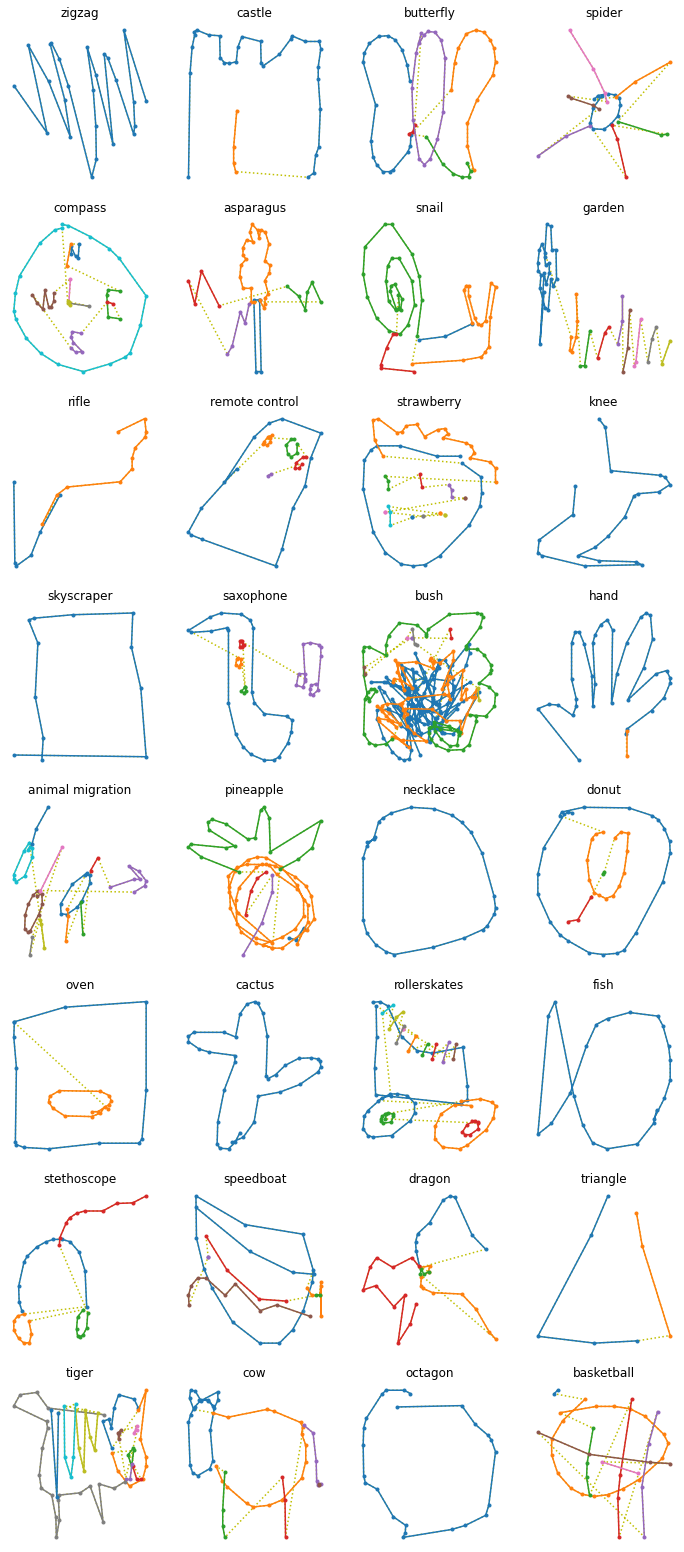

In [20]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

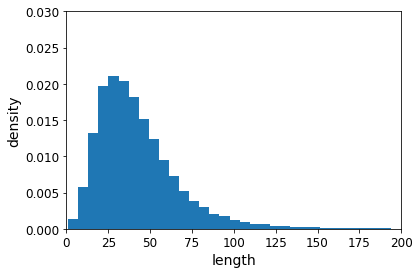

In [22]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins = 150, density = True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [24]:
def crop_long_sketches(dataset, max_length = 100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [30]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size = 5, strides = 2, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size = 5, strides = 2, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size = 3, strides = 2, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences = True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation = "softmax")
])

optimizer = keras.optimizers.SGD(lr = 1e-2, clipnorm = 1.)
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = optimizer,
             metrics = ["accuracy", "sparse_top_k_categorical_accuracy"])

history = model.fit(cropped_train_set, epochs = 4, 
                    validation_data = cropped_valid_set)

Epoch 1/4
107813/107813 [==============================] - 968s 9ms/step - loss: 4.0957 - accuracy: 0.1688 - sparse_top_k_categorical_accuracy: 0.3712 - val_loss: 3.1240 - val_accuracy: 0.3000 - val_sparse_top_k_categorical_accuracy: 0.5833
Epoch 2/4
107813/107813 [==============================] - 933s 9ms/step - loss: 2.7167 - accuracy: 0.3770 - sparse_top_k_categorical_accuracy: 0.6664 - val_loss: 2.5025 - val_accuracy: 0.4139 - val_sparse_top_k_categorical_accuracy: 0.7072
Epoch 3/4
107813/107813 [==============================] - 935s 9ms/step - loss: 2.3240 - accuracy: 0.4524 - sparse_top_k_categorical_accuracy: 0.7387 - val_loss: 2.2358 - val_accuracy: 0.4694 - val_sparse_top_k_categorical_accuracy: 0.7534
Epoch 4/4
107813/107813 [==============================] - 927s 9ms/step - loss: 2.1174 - accuracy: 0.4941 - sparse_top_k_categorical_accuracy: 0.7736 - val_loss: 2.0162 - val_accuracy: 0.5136 - val_sparse_top_k_categorical_accuracy: 0.7911


In [31]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [32]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.67731035

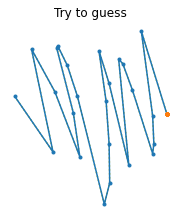

Top-5 predictions:
  1. zigzag 42.012%
  2. line 24.894%
  3. ocean 12.246%
  4. rainbow 3.691%
  5. the great wall of china 3.481%
Answer: zigzag


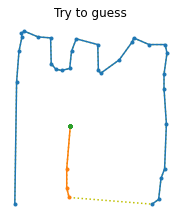

Top-5 predictions:
  1. line 23.960%
  2. fence 22.862%
  3. zigzag 10.132%
  4. the great wall of china 8.614%
  5. skyscraper 5.651%
Answer: castle


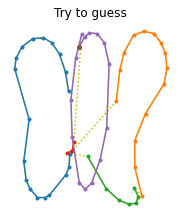

Top-5 predictions:
  1. peanut 17.807%
  2. watermelon 10.847%
  3. violin 8.152%
  4. moon 7.426%
  5. squiggle 4.721%
Answer: butterfly


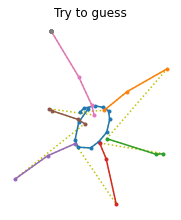

Top-5 predictions:
  1. vase 18.445%
  2. hexagon 9.818%
  3. octagon 8.992%
  4. ceiling fan 8.770%
  5. shovel 6.793%
Answer: spider


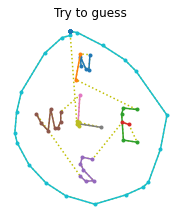

Top-5 predictions:
  1. onion 38.527%
  2. bracelet 13.125%
  3. blueberry 7.962%
  4. necklace 5.139%
  5. smiley face 5.018%
Answer: compass


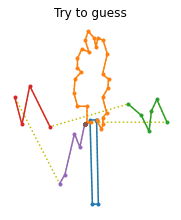

Top-5 predictions:
  1. grass 16.703%
  2. ocean 11.442%
  3. line 10.190%
  4. animal migration 8.722%
  5. bush 5.370%
Answer: asparagus


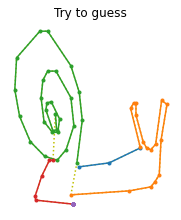

Top-5 predictions:
  1. watermelon 20.616%
  2. moon 16.647%
  3. peanut 5.928%
  4. onion 5.479%
  5. hockey puck 4.502%
Answer: snail


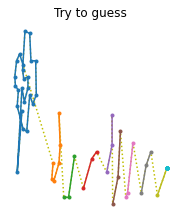

Top-5 predictions:
  1. grass 17.576%
  2. line 16.073%
  3. vase 6.240%
  4. blackberry 5.535%
  5. animal migration 4.805%
Answer: garden


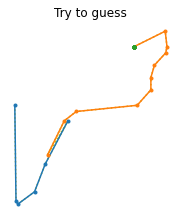

Top-5 predictions:
  1. shovel 13.191%
  2. line 8.596%
  3. garden hose 7.433%
  4. stairs 4.236%
  5. golf club 3.701%
Answer: rifle


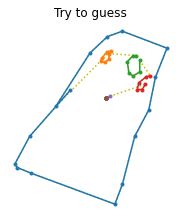

Top-5 predictions:
  1. hat 24.467%
  2. snowman 7.131%
  3. smiley face 4.474%
  4. mountain 3.331%
  5. hot dog 3.298%
Answer: remote control


In [33]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k = 5)
for index in range(n_new):
    plt.figure(figsize = (3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index+1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k+1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [34]:
model.save("sketchrnn.h5")